# Notebook 5 — Diagnostics & Interpretability

Purpose:
- Load the feature-engineered dataset and best hyperparameters from previous notebooks
- Train final models (using selected params) on the training portion and evaluate on the holdout
- Produce per-region/per-month diagnostics, residual analysis, permutation importance, and SHAP summaries (if installed)
- Save diagnostic CSVs and plots to ../4_data_analysis/model_datasets/

Notes:
- This notebook expects the feature-engineered CSV (../4_data_analysis/model_datasets/model_ready_dataset_fe.csv) and best_params.json from Notebook 4.

In [ ]:
# Imports & paths
import os
import json
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
sns.set()

fe_path = os.path.join('..','4_data_analysis','model_datasets','model_ready_dataset_fe.csv')
params_path = os.path.join('..','4_data_analysis','model_datasets','best_params.json')
out_dir = os.path.join('..','4_data_analysis','model_datasets')
os.makedirs(out_dir, exist_ok=True)

if not os.path.exists(fe_path):
    raise FileNotFoundError(f'FE dataset not found at {fe_path}. Run Notebook 3 first.')
df = pd.read_csv(fe_path)
print('Loaded FE data shape:', df.shape)

best_params = {}
if os.path.exists(params_path):
    with open(params_path) as f:
        best_params = json.load(f)
    
print('Loaded best params keys:', list(best_params.keys()))



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\amhx1\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "c:\Users\amhx1\anaconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\amhx1\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "c:\Users\amhx1\anaconda3\Lib\site-pack

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import

In [ ]:
# Ensure Time column and region counts
if 'Time' not in df.columns:
    df = df.sort_values(['REGION','YEAR','Month_Num']).reset_index(drop=True)
    df['Time'] = df.groupby('REGION').cumcount()
print('Per-region counts:')
print(df.groupby('REGION').size())


Per-region counts:
REGION
Central    408
East       408
North      408
South      408
West       408
dtype: int64


In [ ]:
# Train/test split: last N months per region (same as Notebook 3)
def train_test_time_split(df, group_col='REGION', time_col='Time', test_periods=24):
    train_parts, test_parts = [], []
    for name, g in df.groupby(group_col):
        g_sorted = g.sort_values(time_col).reset_index(drop=True)
        if len(g_sorted) <= test_periods:
            raise ValueError(f"Region {name} has <= {test_periods} rows; reduce test_periods or drop region")
        train_parts.append(g_sorted.iloc[:-test_periods].copy())
        test_parts.append(g_sorted.iloc[-test_periods:].copy())
    return pd.concat(train_parts).reset_index(drop=True), pd.concat(test_parts).reset_index(drop=True)

train_df, test_df = train_test_time_split(df, test_periods=30)
print('Train shape:', train_df.shape, 'Test shape:', test_df.shape)


Train shape: (1890, 21) Test shape: (150, 21)


Select model + features and target variant to analyze.
- If you used log1p in model selection, pick that path (we will apply inverse transform and clip negatives for diagnostics).
We'll default to RandomForest with saved best params if available, otherwise train a small RF with defaults as a fallback.

In [ ]:
target = 'Rainfall'
features = [c for c in df.columns if c not in ['REGION','YEAR','Month','Month_Num','Rainfall','Temperature','Time']]
features = ['YEAR','Time','Month_sin','Month_cos'] + [c for c in features if ('lag' in c or '_roll' in c)]
features = [c for c in features if c in train_df.columns]
print('Number of features used:', len(features))

# choose params
rf_params = best_params.get('rf_raw') or best_params.get('rf_log1p') or {'n_estimators':200, 'max_depth':10}
print('RF params used:', rf_params)

# train RF on training set
X_tr = train_df[features]
y_tr = train_df[target]
X_te = test_df[features]
y_te = test_df[target]

rf = RandomForestRegressor(n_jobs=-1, **{k:v for k,v in rf_params.items() if k in ['n_estimators','max_depth','max_features']})
rf.fit(X_tr, y_tr)
pred = rf.predict(X_te)
# Postprocess (clip negatives) — rainfall cannot be negative
pred = np.clip(pred, 0, None)

def metrics(y_true, y_pred):
    return {'rmse': np.sqrt(mean_squared_error(y_true, y_pred)), 'mae': mean_absolute_error(y_true, y_pred), 'r2': r2_score(y_true, y_pred)}

overall = metrics(y_te, pred)
print('Overall test metrics (RF):', overall)


Number of features used: 16
RF params used: {'n_estimators': 200, 'max_depth': 10, 'max_features': 0.5}
Overall test metrics (RF): {'rmse': 0.9120464306660646, 'mae': 0.49838788001457884, 'r2': 0.8563900193020378}


In [ ]:
# Per-region metrics and save
test_df = test_df.copy()
test_df['pred'] = pred

rows = []
for region, g in test_df.groupby('REGION'):
    rows.append({'REGION': region, **metrics(g[target], g['pred']), 'n': len(g)})
per_region_metrics = pd.DataFrame(rows).sort_values('rmse', ascending=True)
per_region_metrics.to_csv(os.path.join(out_dir, 'per_region_metrics.csv'), index=False)
print('Saved per-region metrics to', os.path.join(out_dir, 'per_region_metrics.csv'))
display(per_region_metrics.head(50))


Saved per-region metrics to ..\4_data_analysis\model_datasets\per_region_metrics.csv


,REGION,rmse,mae,r2,n
2,North,0.199413,0.114007,0.656619,30
0,Central,0.808662,0.467142,0.738918,30
1,East,0.894576,0.525842,0.300109,30
4,West,0.994330,0.602909,0.871531,30
3,South,1.294791,0.782039,0.851639,30


Residual diagnostics and plots — overall and by region (shows where model fails).

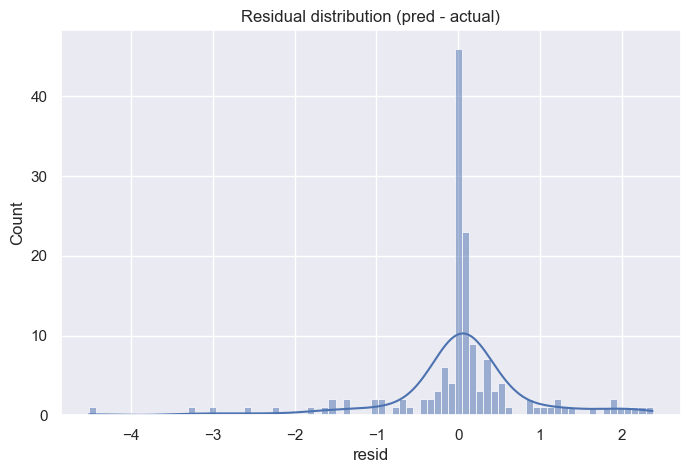

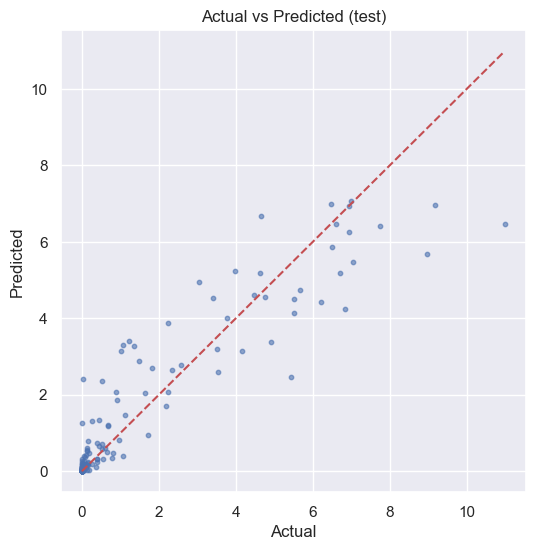

In [ ]:
test_df['resid'] = test_df['pred'] - test_df[target]

plt.figure(figsize=(8,5))
sns.histplot(test_df['resid'], bins=80, kde=True)
plt.title('Residual distribution (pred - actual)')
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(test_df[target], test_df['pred'], alpha=0.6, s=10)
plt.plot([test_df[target].min(), test_df[target].max()], [test_df[target].min(), test_df[target].max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted (test)')
plt.show()


Permutation importance (global) — a model-agnostic ranking of features using the test set.

In [ ]:
perm = permutation_importance(rf, X_te, y_te, n_repeats=10, random_state=42, n_jobs=-1)
imp_df = pd.DataFrame({'feature': X_te.columns, 'importance_mean': perm.importances_mean, 'importance_std': perm.importances_std})
imp_df = imp_df.sort_values('importance_mean', ascending=False)
imp_df.to_csv(os.path.join(out_dir, 'permutation_importance.csv'), index=False)
print('Top features by permutation importance:')
display(imp_df.head(30))


Top features by permutation importance:


,feature,importance_mean,importance_std
7,Rainfall_lag_12,6.430304e-01,7.088278e-02
4,Rainfall_lag_1,8.137769e-02,9.941839e-03
3,Month_cos,4.180088e-02,1.180180e-02
13,Rainfall_roll12,3.765606e-02,7.353658e-03
12,Rainfall_roll3,1.876330e-02,8.674730e-03
10,Temperature_lag_3,9.983667e-03,3.307901e-03
8,Temperature_lag_1,6.759352e-03,2.241307e-03
5,Rainfall_lag_2,6.532755e-03,5.476287e-03
11,Temperature_lag_12,6.374311e-03,2.268043e-03
9,Temperature_lag_2,5.576763e-03,2.870260e-03


SHAP explanations (if library installed). This can be slow for large datasets — we compute SHAP for a small sample.
If SHAP is not available the cell will print a note and continue.

In [ ]:
try:
    import shap
    # sample for SHAP
    X_sample = X_te.sample(min(500, len(X_te)), random_state=42)
    explainer = shap.TreeExplainer(rf)
    shap_values = explainer.shap_values(X_sample)
    print('Computed SHAP values for sample. Plotting summary (may take a moment)...')
    shap.summary_plot(shap_values, X_sample, show=True)
except Exception as e:
    print('SHAP unavailable or failed:', e)
    print('Install shap (pip install shap) to enable SHAP plots')


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.12 from "c:\Users\amhx1\anaconda3\python.exe"
  * The NumPy version is: "1.26.4"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed while importing _multiarray_umath: The specified module could not be found.


SHAP unavailable or failed: numpy._core.multiarray failed to import
Install shap (pip install shap) to enable SHAP plots


In [ ]:
# Save the trained RF model for later (Notebook 6)
model_out = os.path.join(out_dir, 'final_rf_model_joblib.pkl')
joblib.dump(rf, model_out)
print('Saved RF model to', model_out)

# Save test_df with predictions
test_df.to_csv(os.path.join(out_dir, 'test_with_preds.csv'), index=False)
print('Saved test set with preds to', os.path.join(out_dir, 'test_with_preds.csv'))


Wrap-up:
- Check per-region_metrics.csv for which regions have worst RMSE and inspect those time series and residuals.
- If log1p transforms gave bad original-scale RMSE, inspect predictions for large rainfall months as described earlier.
- Next notebook (6) will use the saved model(s) to produce multi-step forecasts and save final outputs for stakeholders.